# Smallpox Paradox (p50)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://pyagrum.gitlab.io) |[ ![interactive online version](images/atbinder.svg)](https://mybinder.org/v2/gl/agrumery%2FaGrUM/forBinder?urlpath=%2Fdoc%2Ftree%2Fwrappers%2Fpyagrum%2Fdoc%2Fsphinx%2Fnotebooks%2FBoW-c1p050-smallPox.ipynb)

Authors: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

**This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 1 page 050**

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb

>"When the smallpox vaccine was first introduced. Unexpectedly, data showed that more people died from
smallpox inoculations than from smallpox itself. Naturally, some people used
this information to argue that inoculation should be banned, when in fact it
was saving lives by eradicating smallpox. Let’s look at some fictitious data to
illustrate the effect and settle the dispute. We have a population of one million children." chapter1, page 50.

### Derived causal diagram:
* The vaccination rate is set to 0.99.
    * You have a 0.01 probability of developing a reaction to the vaccine.
    * You have a 0.02 probability of contracting smallpox if you don't get vaccinated.
        * You have a 0.01 probability of dying from a reaction to the vaccine.
        * You have a 0.2 probability of dying from smallpox.
       
The corresponding causal diagram is the following:

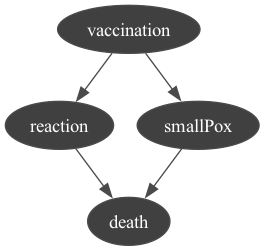

In [2]:
sp = gum.fastBN("vaccination->reaction->death<-smallPox<-vaccination")

gum.config.push()
gum.config["notebook", "graph_format"] = "png"
gnb.show(sp)
gum.config.pop()

In [3]:
# filling the CPTs

# This function adds a uniform noise to a CPT
def smallPertubation(cpt, epsilon=0.0001):
  cpt.fillWith(cpt.translate(epsilon).normalizeAsCPT())


# Fictitious data
sp.cpt("vaccination")[:] = [0.01, 0.99]
sp.cpt("reaction")[{"vaccination": 0}] = [1, 0]
sp.cpt("reaction")[{"vaccination": 1}] = [0.99, 0.01]
sp.cpt("smallPox")[{"vaccination": 0}] = [0.98, 0.02]
sp.cpt("smallPox")[{"vaccination": 1}] = [1, 0]

sp.cpt("death")[{"reaction": 0, "smallPox": 0}] = [1, 0]
sp.cpt("death")[{"reaction": 0, "smallPox": 1}] = [0.8, 0.2]
sp.cpt("death")[{"reaction": 1, "smallPox": 0}] = [0.99, 0.01]
# This case is not possible
sp.cpt("death")[{"reaction": 1, "smallPox": 1}] = [0.5, 0.5]


# We add a uniform noise to the CPTs
epsilon = 0.000000001
smallPertubation(sp.cpt("reaction"), epsilon)
smallPertubation(sp.cpt("smallPox"), epsilon)
smallPertubation(sp.cpt("death"), epsilon)

In [4]:
gnb.sideBySide(
  sp,
  sp.cpt("vaccination"),
  sp.cpt("reaction"),
  sp.cpt("smallPox"),
  sp.cpt("death"),
  captions=[
    "the BN",
    "the marginal for $vaccination$",
    "the CPT for $reaction$",
    "the CPT for $smallPox$",
    "the CPT for $death$",
  ],
)

In [5]:
# gum.saveBN(sp,os.path.join("out","smallPox.o3prm"))

### Observational statement

We have that :
$$P(reaction = 1 \mid vaccination = 1 ) < P(smallPox = 1 \mid vaccination = 0 )$$
$$P(death = 1 \mid reaction = 1) < P(death = 1 \mid smallPox = 1)$$
> We know that the probability of developing a reaction to the vaccine is lower than the probability of contracting smallpox if one does not vaccinate. We also know that the probability of dying from smallpox is greater than the probability of dying from a reaction to the vaccine. (smallpox is more threatening to one's life than a reaction to the vaccine)

In [6]:
def getAliveObservedProba(sp, evs):
  evs0 = dict(evs)
  evs1 = dict(evs)
  evs0["vaccination"] = 0
  evs1["vaccination"] = 1

  return (
    gum.Tensor()
    .add(sp["vaccination"])
    .fillWith([gum.getPosterior(sp, target="death", evs=evs0)[1], gum.getPosterior(sp, target="death", evs=evs1)[1]])
  )


gnb.sideBySide(
  getAliveObservedProba(sp, {}),
  captions=[
    r"$P(death = 1 \mid vaccination )$<br/>$P(death = 1 \mid vaacination = 0) > P(death = 1 \mid vaacination = 1)$"
  ],
)

Based on this information, we can say that vaccination is a good choice. However, more children die from vaccination than from smallpox itself according to the data:
* Number of people dying from a reaction:
$$P(vaccination = 1) \times P(reaction = 1 \mid vaccination = 1) \times P(death = 1 \mid reaction = 1) \times 1000000 = 99$$
* Number of people dying from smallpox:
$$P(vaccination = 0) \times P(smallPox = 1 \mid vaccination = 0) \times P(death = 1 \mid smallPox = 1) \times 1000000 = 40$$
<b>In total if the vaccination rate is set to 99% we have 139 deaths. </b>

## Counterfactual

When we began, the vaccination rate was 99 percent. We now ask the counterfactual question “What if we had set the vaccination rate to zero?”

In [7]:
# Counterfactual world where the vaccination rate is set to 0
spCounterfactual = gum.BayesNet(sp)
spCounterfactual.cpt("vaccination")[:] = [1, 0]

In [8]:
gnb.sideBySide(
  gnb.getInference(sp),
  gnb.getInference(spCounterfactual),
  captions=[
    "<b>factual world:</b> the vaccination rate is set to 0.99 <br> lower risk of contracting smallpox, higher risk of developing a reaction, lower probability of death",
    "<b>counterfactual world:</b> the vaccination rate is set to 0 <br> higher risk of contracting smallpox, lower risk of developing a reaction, higher probability of death",
  ],
)

The probability of death in the counterfactual world is higher.<br>
* Number of deaths in this case:
$$P(vaccination = 0) \times P(smallPox = 1 \mid vaccination = 0) \times P(death = 1 \mid smallPox = 1) \times 1000000 = 4000$$

## Conclusion for the smallpox Paradox

In total, if the vaccination rate is set to 0%, we have 4000 deaths, compared to 139 deaths if the vaccination rate is set to 99%. Vaccination is definitely a good choice !

> More people died from a reaction than from smallpox itself because with a vaccination rate of 0.99% the probability of developing a reaction was much higher than the probability of contracting smallpox (almost null) (since 99% of the population got vaccinated $\implies$ 99% of the population had a 0.001 probability of developing a reaction, while only 1% of the population had a 0.2 percent probability of contracting smallpox) that's why we saw that the effect of a reaction on death was greater than the effect of smallpox.(we recorded the effect of a reaction to the vaccine on a much greater population)

### Causal impact of reaction/vaccination on death :
Corresponds to the former results

In [9]:
spModele = csl.CausalModel(sp)
cslnb.showCausalImpact(spModele, on="death", doing="reaction", values={"reaction": 1})

In [10]:
spModele = csl.CausalModel(sp)
cslnb.showCausalImpact(spModele, on="death", doing="smallPox", values={"smallPox": 1})